In [433]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

In [434]:
# python port of SMC control from ENGG*6490
# Spencer Ploeger

In [435]:
# define SMC control function
def smc_controller_func(t,state,F,lamda,n,A,B,C,D):
    x0, x1, x2, x3, x4, x5, x6, x7 = state
    Kval = n + F + 0.01; # Controller Parameter, K
    L = np.diag(lamda); # Matrix to hold lamda values

    ## Desired Trajectory
    q_d = np.matrix([[np.cos(t)], [np.sin(t)], [np.cos(t)], [np.sin(t)]])
    qdot_d = np.matrix([[-1*np.sin(t)], [np.cos(t)], [-1*np.sin(t)], [np.cos(t)]]) #desired vel
    qddot_d = np.matrix([[-1*np.cos(t)], [-1*np.sin(t)], [-1*np.cos(t)], [-1*np.sin(t)]])

    # if t < 50:
    #     q_d = np.matrix([[5*t], [5*t], [-5*t], [-5*t]])
    #     qdot_d = np.matrix([[5], [5], [-5], [-5]]) # desired vel
    #     qddot_d = np.matrix([[0], [0], [0], [0]])
    # else:
    #     q_d = np.matrix([[9*t], [9*t], [-9*t], [-9*t]])
    #     qdot_d = np.matrix([[9], [9], [-9], [-9]]) # desired vel
    #     qddot_d = np.matrix([[0], [0], [0], [0]])


    e = np.matrix([[x0], [x2], [x4], [x6]]) - qdot_d # error
    edot = np.matrix([[x1], [x3], [x5], [x7]]) - qddot_d # error dot
    s = edot + lamda*e # s

    k1 = Kval*np.sign(s[0]); # var to hold k1 * sign(s1)
    k2 = Kval*np.sign(s[1]); # var to hold k2 * sign(s2)
    k3 = Kval*np.sign(s[2]); # var to hold k3 * sign(s3)
    k4 = Kval*np.sign(s[3]); # var to hold k4 * sign(s4)

    #System dynamics
    xd_0 = x1; # q_dot(1) wheel 1 vel.
    xd_1 = qddot_d[0] - L[0]*(x1-qdot_d[0]) - (C*k1 -B*k2 +B*k3 +D*k4); # q_ddot(1)
    xd_2 = x3; # q_dot(2) wheel 2 vel.
    xd_3 = qddot_d[1] - L[1]*(x3-qdot_d[1]) - (-B*k1 +C*k2 +D*k3 +B*k4); # q_ddot(2)
    xd_4 = x5; # q_dot(3) wheel 3 vel.
    xd_5 = qddot_d[2] - L[2]*(x5-qdot_d[2]) - (B*k1 +D*k2 +C*k3 -B*k4); # q_ddot(3)
    xd_6 = x7; # q_dot(4) wheel 4 vel.
    xd_7 = qddot_d[3] - L[3]*(x7-qdot_d[3]) - (D*k1 +B*k2 -B*k3 +C*k4); # q_ddot(4)

    return [xd_0, xd_1, xd_2, xd_3, xd_4, xd_5, xd_6, xd_7]

In [436]:
# System Parameters (Robot Characteristics)
m = 100 # mass [kg]
r = 0.1 # radius of wheels [m]
L = 0.5 # vertical (y) distance from centre of wheels to COM [m]
W = 0.3 # horizontal (x) distance from centre of wheels to COM [m]
Iz = 5 # moment of intertia for robot [kg*m^2]
Iw = 0.05 # moment of intertia for wheels [kg*m^2]

## Construct system kinematics matrices
A = (m*r**2)/8
B = (Iz*r**2)/(16*(W+L)**2)
C = A+B+Iw
D = A-B

# SMC controller parameters
F = 0.05; # assume this is known/given
Lval = 1
lamda = np.diag((Lval, Lval, Lval, Lval)); # choose lamda
n = 0.8; # choose eta

p = (F,lamda,n,A,B,C,D)

In [437]:
## Initial conditions for all four wheels
## Assume q = 1 for all wheels, q_dot (velocity) = 0
x0 = [0,0,0,0,0,0,0,0] # initial conditions
tspan = (0, 100); # Simulation time span
t=np.arange(0,100,0.1)

In [438]:
desired3 = np.matrix(np.empty((4,len(t))))
for itr in range(1,len(t)):
    if(t[itr] < 50):
        desired3[0,itr] = 5
        desired3[1,itr] = 5
        desired3[2,itr] = -5
        desired3[3,itr] = -5
    else:
        desired3[0,itr] = 9
        desired3[1,itr] = 9
        desired3[2,itr] = -9
        desired3[3,itr] = -9

In [439]:
# call ode45 equivalent here
# [t,y] = ode45(@(t,x) smc_controller_func(t,x,F,lamda,n,A, B, C, D), tspan, x0); % Call the controller function
result_solve_ivp = solve_ivp(smc_controller_func, tspan, x0, args=p, method='LSODA',t_eval=t)

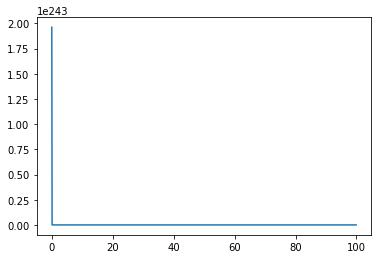

In [440]:
plt.plot(t,desired3[2,:].reshape(1000,1))
#print(desired3[0,:])

0


Text(0.5, 14.999999999999972, 'Time [s]')

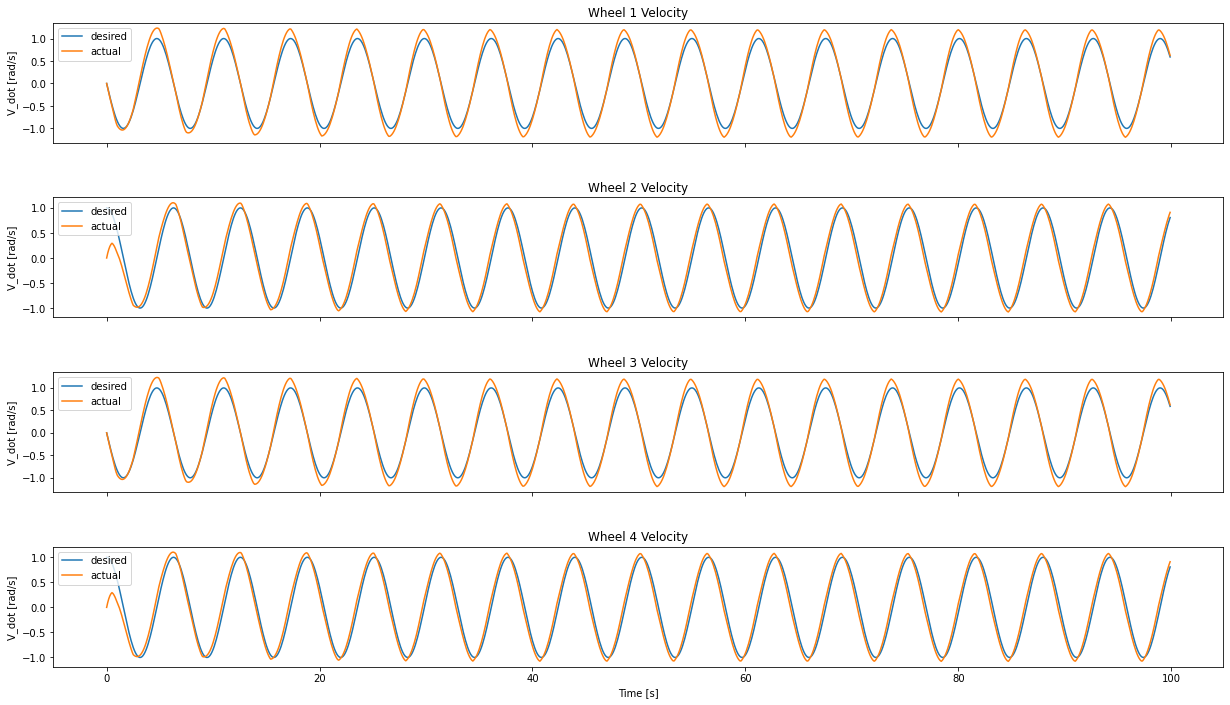

In [441]:
fig, axs = plt.subplots(4, sharex=True)
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
#offset= 3*np.pi/2
offset = 0
print(offset)
t=np.arange(0-offset,100-offset,0.1)

axs[0].plot(t, -1*np.sin(t), label = "desired")
axs[0].plot(t,result_solve_ivp.y[1,:], label = "actual")
axs[0].set_title("Wheel 1 Velocity")
axs[0].set(ylabel='V_dot [rad/s]')
axs[0].legend(loc='upper left')

axs[1].plot(t, np.cos(t), label = "desired")
axs[1].plot(t, result_solve_ivp.y[3,:], label = "actual")
axs[1].set_title("Wheel 2 Velocity")
axs[1].set(ylabel='V_dot [rad/s]')
axs[1].legend(loc='upper left')

axs[2].plot(t, -1*np.sin(t), label = "desired")
axs[2].plot(t, result_solve_ivp.y[5,:], label = "actual")
axs[2].set_title("Wheel 3 Velocity")
axs[2].set(ylabel='V_dot [rad/s]')
axs[2].legend(loc='upper left')

axs[3].plot(t, np.cos(t), label = "desired")
axs[3].plot(t, result_solve_ivp.y[7,:], label = "actual")
axs[3].set_title("Wheel 4 Velocity")
axs[3].set(ylabel='V_dot [rad/s]')
axs[3].legend(loc='upper left')


# axs[0].plot(t, desired3[0,:].reshape(1000,1), label = "desired")
# axs[0].plot(t,result_solve_ivp.y[1,:], label = "actual")
# axs[0].set_title("Wheel 1 Velocity")
# axs[0].set(ylabel='V_dot [rad/s]')
# axs[0].legend(loc='upper left')

# axs[1].plot(t, desired3[1,:].reshape(1000,1), label = "desired")
# axs[1].plot(t, result_solve_ivp.y[3,:], label = "actual")
# axs[1].set_title("Wheel 2 Velocity")
# axs[1].set(ylabel='V_dot [rad/s]')
# axs[1].legend(loc='upper left')

# axs[2].plot(t, desired3[2,:].reshape(1000,1), label = "desired")
# axs[2].plot(t, result_solve_ivp.y[5,:], label = "actual")
# axs[2].set_title("Wheel 3 Velocity")
# axs[2].set(ylabel='V_dot [rad/s]')
# axs[2].legend(loc='upper left')

# axs[3].plot(t, desired3[3,:].reshape(1000,1), label = "desired")
# axs[3].plot(t, result_solve_ivp.y[7,:], label = "actual")
# axs[3].set_title("Wheel 4 Velocity")
# axs[3].set(ylabel='V_dot [rad/s]')
axs[3].legend(loc='upper left')

plt.xlabel("Time [s]")

0


Text(0.5, 14.999999999999972, 'Time [s]')

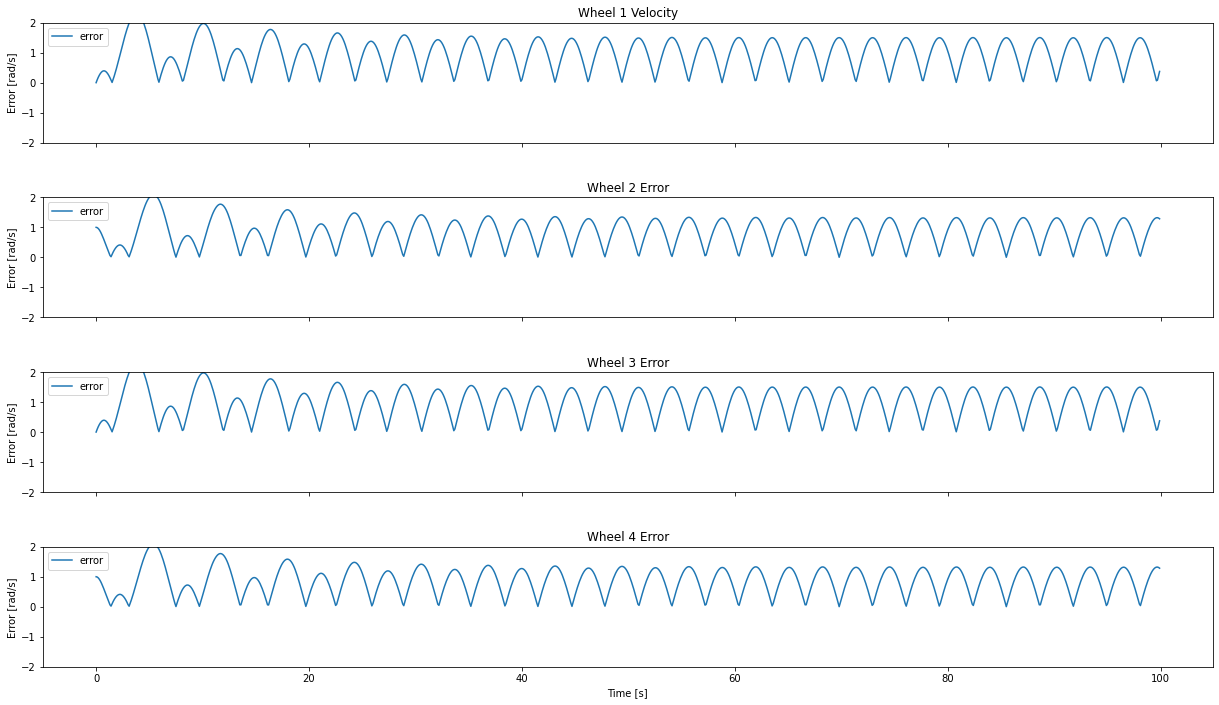

In [442]:
fig, axs = plt.subplots(4, sharex=True)
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
#offset= 3*np.pi/2
offset = 0
print(offset)
t=np.arange(0-offset,100-offset,0.1)

axs[0].plot(t, abs(-1*np.sin(t)-result_solve_ivp.y[0,:]), label = "error")
axs[0].set_title("Wheel 1 Velocity")
axs[0].set(ylabel='Error [rad/s]')
axs[0].legend(loc='upper left')
axs[0].set_ylim([-2,2])

axs[1].plot(t, abs(np.cos(t)-result_solve_ivp.y[2,:]), label = "error")
axs[1].set_title("Wheel 2 Error")
axs[1].set(ylabel='Error [rad/s]')
axs[1].legend(loc='upper left')
axs[1].set_ylim([-2,2])

axs[2].plot(t, abs(-1*np.sin(t)-result_solve_ivp.y[4,:]), label = "error")
axs[2].set_title("Wheel 3 Error")
axs[2].set(ylabel='Error [rad/s]')
axs[2].legend(loc='upper left')
axs[2].set_ylim([-2,2])

axs[3].plot(t, abs(np.cos(t)-result_solve_ivp.y[6,:]), label = "error")
axs[3].set_title("Wheel 4 Error")
axs[3].set(ylabel='Error [rad/s]')
axs[3].legend(loc='upper left')
axs[3].set_ylim([-2,2])

plt.xlabel("Time [s]")